# Notebook for responding to the Google Form about Predicting MMSE scores

This notebook is the code to respond to the google form https://docs.google.com/forms/d/e/1FAIpQLSfKuRvqtKkMWoycQKUdDfc7HM-Ni73XON573PxgY9RiNIYidw/viewform?vc=0&c=0&w=1&flr=0. We will take the responses from a user and send them an email with their predicted change in MMSE score using the machine learning model developed in "PredictingChangeinMMSE.ipynb."

In [1]:
import pandas as pd

In [2]:
df = pd.read_csv("Form.csv") # Getting the information from the google sheet 

In [3]:
df = df.tail(1) #Getting the latest row

In [4]:
df

,Timestamp,Name,Email,Date,"Diagnosis at baseline test (4 options: CN, EMCI, LMCI, AD)",Age at baseline test,Biological Gender,Years of Education,"Enter your ApoE4 genotype. One way to receive the genotype is by purchasing a 23andMe genetic test (requiring a saliva sample). A 23andMe kit (with health information) costs $199, but it's worth the price as the information about your health is invaluable",Please take a MMSE test and type your score below (number only),"Please enter your APOE Genotype. If you don't enter it properly you'll not receive an accurate reading (Ex: 2,3 or 3,3)."
0,3/2/21 0:13,Rohan Penmatcha,rpenmatc@gmail.com,2/10/21,CN,73,Male,16,0,29,"3,3"


In [5]:
email = df['Email']
Input = df['Date']
Input = df.drop(['Timestamp', 'Name', 'Email', 'Date'], axis=1) # Remove Unneccesary Data


In [6]:
email 

0    rpenmatc@gmail.com
Name: Email, dtype: object

In [7]:
Input = Input.rename(columns={'Diagnosis at baseline test (4 options: CN, EMCI, LMCI, AD)': 'DX.bl'})


In [8]:
Input = Input.rename(columns={'Age at baseline test': 'AGE'})
Input = Input.rename(columns={'Biological Gender': 'PTGENDER'})
Input = Input.rename(columns={'Years of Education': 'PTEDUCAT'})
Input = Input.rename(columns ={"Enter your ApoE4 genotype. One way to receive the genotype is by purchasing a 23andMe genetic test (requiring a saliva sample).  A 23andMe kit (with health information) costs $199, but it's worth the price as the information about your health is invaluable " : "APOE4"})
Input = Input.rename(columns={'Please take a MMSE test and type your score below (number only)': 'MMSE'})
Input = Input.rename(columns={"Please enter your APOE Genotype. If you don't enter it properly you'll not receive an accurate reading (Ex: 2,3 or 3,3).": 'APOE Genotype'})
Input = Input.rename(columns={"Please enter your APOE Genotype. If you don't enter it properly you'll not receive an accurate reading (Ex: 2,3 or 3,3). ": 'APOE Genotype'})
# Renaming the data to fit the model and for simplicity

In [9]:
Input

,DX.bl,AGE,PTGENDER,PTEDUCAT,APOE4,MMSE,APOE Genotype
0,CN,73,Male,16,0,29,"3,3"


In [10]:
MMSE_BASELINE_SCORE = Input.loc[0, 'MMSE']
MMSE_BASELINE_SCORE = str(MMSE_BASELINE_SCORE) #Getting the baseline MMSE score

In [11]:
import numpy as np
import sklearn as sk
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import math 

from numpy import mean
from numpy import std
from numpy import absolute
from math import sqrt
from numpy.random import randn
from sklearn.model_selection import train_test_split
from sklearn import svm
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import explained_variance_score
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import RepeatedKFold

warnings.filterwarnings('ignore')
%matplotlib inline

In [12]:
data = pd.read_csv("ADNI_Training_Q1_APOE_July22.2014.csv") # Get the Data
data = data.drop(['RID', 'PTID', 'VISCODE', 'EXAMDATE'], axis=1) # Remove Unneccesary Data
data = data.append(Input) #Adding the User's data for preprocessing
categorical_variables = ['DX.bl', 'PTGENDER', 'APOE Genotype']
numerical_variables = ['AGE','PTEDUCAT', 'APOE4', 'MMSE']
for var in categorical_variables:
    data = pd.concat([data, pd.get_dummies(data[var])], axis=1)
    data = data.drop(var, axis=1)
# Implements One Hot Encoder for the purpose of replacing the Categorical Values with Numerical Values to implement regression models

In [13]:
r = len(data)
Input = data.iloc[[r - 1]]
Input #Getting the information for the user after running through One Hot Encoder

,AGE,PTEDUCAT,APOE4,MMSE,AD,CN,EMCI,LMCI,Female,Male,"2,2","2,3","2,4","3,3","3,4","4,4"
0,73.0,16,0,29,0,1,0,0,0,1,0,0,0,1,0,0


In [14]:
data = data[:1534] #Removing the User's input from the data 

In [15]:
data

,AGE,PTEDUCAT,APOE4,MMSE,AD,CN,EMCI,LMCI,Female,Male,"2,2","2,3","2,4","3,3","3,4","4,4"
0,73.7,16,0,29,0,1,0,0,0,1,0,0,0,1,0,0
1,73.7,16,0,29,0,1,0,0,0,1,0,0,0,1,0,0
2,80.4,13,0,25,0,0,0,1,1,0,0,0,0,1,0,0
3,80.4,13,0,26,0,0,0,1,1,0,0,0,0,1,0,0
4,80.0,19,0,29,0,0,0,1,1,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1529,61.9,12,2,27,0,0,1,0,1,0,0,0,0,0,0,1
1530,71.1,12,2,25,1,0,0,0,0,1,0,0,0,0,0,1
1531,71.1,12,2,21,1,0,0,0,0,1,0,0,0,0,0,1
1532,79.4,16,2,22,1,0,0,0,0,1,0,0,0,0,0,1


In [16]:
r, c = data.shape
MMSE_SCORE = []
for var in range(0,r):
    if (var % 2) == 0:
        continue
    MMSE_SCORE.append(data.at[var,'MMSE'] - data.at[var - 1,'MMSE']) #Calculating the Change in MMSE scores over the 2 year period
data = data[::2] #Removing the final evaluation row for training
data.insert(16, "MMSE_NEW_SCORE",MMSE_SCORE, True) #adding the column
data.head(2)
X = data.drop(["MMSE_NEW_SCORE"], axis=1)
y = data["MMSE_NEW_SCORE"]
r = len(y)
for var in range(0,r): #Edited so that a decline of 5 points is the largest 
    if (var % 2 == 1):
        continue
    if (y.at[var] < -5):
        y.at[var] = -5
    if (y.at[var] > 5):
        y.at[var] = 5
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=120) #Training and Testing sets

In [17]:
X_train.shape

(613, 16)

In [18]:
X_test.shape


(154, 16)

In [19]:
scaler = StandardScaler()
train_scaled = scaler.fit_transform(X_train)
test_scaled = scaler.transform(X_test) #Scaling data

In [20]:
model = ElasticNet(alpha=0.001, l1_ratio=1) #ElasticNet Model

In [21]:
model.fit(X, y)
arr = model.predict(Input) #Predicting the user's change
if (arr > 0):
        if (arr - math.floor(arr) > 0.5):
            arr = math.ceil(arr)
        else: 
            arr = math.floor(arr)
if (arr < 0):
        if (absolute(arr) - absolute(math.ceil(arr)) > 0.5):
            arr = math.floor(arr)
        else: 
            arr = math.ceil(arr)
num = str(arr) #Converting the prediction into an integer and converting it to a string for printing
print("The Predicted Decrease in your MMSE score in the next 2 years is: ", end =" ")
print(num)


The Predicted Decrease in your MMSE score in the next 2 years is:  0


In [22]:
pip install secure-smtplib #required installation to send the email 

Note: you may need to restart the kernel to use updated packages.


In [23]:
import smtplib

gmail_user = 'rpenmatc@gmail.com' #My email that I will use to send the information
gmail_password = 'PASSWORD(HIDDEN FOR PRIVACY)'  #PASSWORD(HIDDEN FOR PRIVACY)

sent_from = gmail_user 
to = ['rpenmatc@gmail.com']
subject = 'YOUR FUTURE MMSE SCORE PREDICTION' 
body = "Hello, thank you for taking your time to fill out this form. The Mini-Mental State Examination (MMSE) is a is a widely used test of cognitive function among the elderly that can show the severity of dementia. \n\nYour predicted future (in around 2 years) MMSE score is " + MMSE_BASELINE_SCORE + ". That is a change of " + num + "  \n\n Here is a link for information to understand what this means: https://www.dementiacarecentral.com/mini-mental-state-exam/. \n\n Thank You, \n Rohan Penmatcha"


email_text = """\
From: %s
To: %s
Subject: %s

%s
""" % (sent_from, ", ".join(to), subject, body)

try:
    server = smtplib.SMTP_SSL('smtp.gmail.com', 465) #Transport Layer Security
    server.ehlo()
    server.login(gmail_user, gmail_password) #Login
    server.sendmail(sent_from, to, email_text) #Sending the Email
    server.close()

    print('SUCCESS! Email was sent!' )
except:
    print ('Something went wrong...' )

SUCCESS! Email was sent!


In [24]:
print ("From the User's point of view, this is how an email will look:")

From the User's point of view, this is how an email will look:


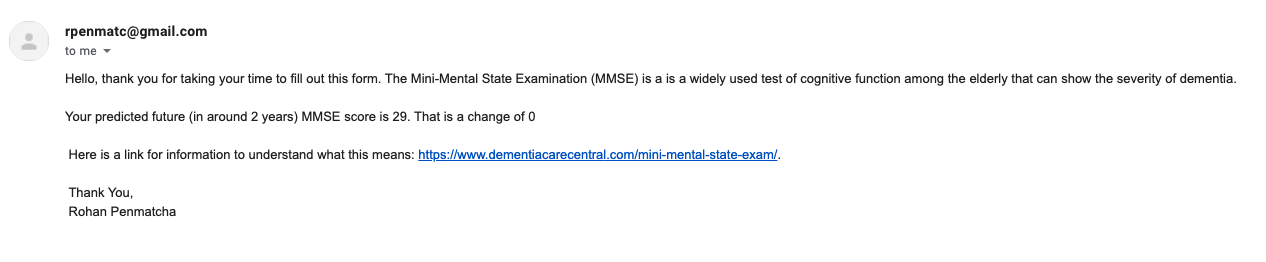

In [25]:
from IPython.display import Image
Image(filename='Example_Email.png') 

# Conclusion 

This notebook succesfully runs the Elastic Net machine learning algorithm to take the responses from a patient and send them an email with their predicted future MMSE score. For future updates, I would like to make this an app that one can download on the appstore rather than a juypter notebook script. However, it still accomplishes this benchmark.